Data collected from a project at Indian Institute of Management Calcutta.

Data source cited:
AQQAD, ABDELRAHIM (2023), “insurance_claims ”, Mendeley Data, V1, doi: 10.17632/992mh7dk9y.1

In [23]:
################
#  Libraries
################

import os
import sys
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, LabelEncoder, 
                                   OrdinalEncoder, FunctionTransformer, KBinsDiscretizer, 
                                   PowerTransformer, MinMaxScaler, RobustScaler, QuantileTransformer)
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from sklearn import set_config
set_config(transform_output="pandas")

from catboost import CatBoostClassifier

from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)
from mapie.metrics import (cumulative_differences, kolmogorov_smirnov_p_value,
                           length_scale)

import relplot as rp


################
#  Configurations
################

class CFG:
    seed = 7113
    unused_cols = ['_c39']
    target_cols = ['fraud_reported']
    cat_cols = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 
                'insured_hobbies', 'insured_relationship', 'incident_type', 'collision_type', 'incident_severity', 
                'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'property_damage', 
                'police_report_available', 'auto_make', 'auto_model']
    date_cols = ['policy_bind_date', 'incident_date']
    # Number of random nested CV trials
    NUM_TRIALS = 2
    inner_cv_num = 8
    outer_cv_num = 8
    n_bins = 9

In [2]:
df = pd.read_csv(r'C:\Users\takehiro\src\Workspace\DS\conformal-prediction-handson\data\insurance_claims.csv')

In [3]:
import pandas as pd

# Description of each column
column_description = [
    'months since he bought the first policy from the company (you may find that difference between bind date and incident)',
    'age of customer',
    'policy id',
    'start date of recorded policy',
    'state in which the policy was bought',
    '250/500 means If you seriously injured one person in an accident you would have $250,000 of liability',
    'the amount that a policy holder has to pay before the insurance company starts paying up',
    'yearly amount paid to the policy',
    'additional excess coverage over the normal limits and coverage of liability policies',
    'zip code of the insured person',
    'gender of the insured person',
    'highest educational qualification of the insured person',
    'occupation of the insured person as recorded',
    'hobby of the insured person as recorded',
    'relationship details of the insured person',
    'gains from the policy',
    'loss from the policy',
    'date on which incident happened',
    'type of the incident',
    'type of the collision',
    'severity of the incident',
    'which law enforcing authority is contacted',
    'state in which the incident occurred',
    'city in which the incident occurred',
    'street details in which the incident occurred',
    'hour of the day at which the incident occurred',
    'number of vehicles involved',
    'whether there was property damage',
    'number of body injuries (0,1,2)',
    'number of witnesses (upto 3)',
    'whether police report is available',
    'total amount claimed',
    'amount claimed for injury',
    'amount claimed for property damage',
    'amount claimed for vehicle damage',
    'make details of the vehicle',
    'model details of the vehicle',
    'manufacturing year of the vehicle',
    'reported details of the fraud person'
]

# List of columns
columns = [
    'months_as_customer',
    'age',
    'policy_number',
    'policy_bind_date',
    'policy_state',
    'policy_csl',
    'policy_deductable',
    'policy_annual_premium',
    'umbrella_limit',
    'insured_zip',
    'insured_sex',
    'insured_education_level',
    'insured_occupation',
    'insured_hobbies',
    'insured_relationship',
    'capital-gains',
    'capital-loss',
    'incident_date',
    'incident_type',
    'collision_type',
    'incident_severity',
    'authorities_contacted',
    'incident_state',
    'incident_city',
    'incident_location',
    'incident_hour_of_the_day',
    'number_of_vehicles_involved',
    'property_damage',
    'bodily_injuries',
    'witnesses',
    'police_report_available',
    'total_claim_amount',
    'injury_claim',
    'property_claim',
    'vehicle_claim',
    'auto_make',
    'auto_model',
    'auto_year',
    'fraud_reported'
]

# Create a dataframe with column description and column names
df_columns = pd.DataFrame({'Column Name': columns, 'Column Description': column_description})
df_columns


,Column Name,Column Description
0,months_as_customer,months since he bought the first policy from t...
1,age,age of customer
2,policy_number,policy id
3,policy_bind_date,start date of recorded policy
4,policy_state,state in which the policy was bought
5,policy_csl,250/500 means If you seriously injured one per...
6,policy_deductable,the amount that a policy holder has to pay bef...
7,policy_annual_premium,yearly amount paid to the policy
8,umbrella_limit,additional excess coverage over the normal lim...
9,insured_zip,zip code of the insured person


In [4]:
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,NaN,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,FEMALE,Masters,craft-repair,paintball,unmarried,0,0,2015-02-22,Single Vehicle Collision,Front Collision,Minor Damage,Fire,NC,Northbrook,6045 Andromedia St,20,1,YES,0,1,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,FEMALE,PhD,prof-specialty,sleeping,wife,70900,0,2015-01-24,Single Vehicle Collision,Rear Collision,Major Damage,Fire,SC,Northbend,3092 Texas Drive,23,1,YES,2,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,FEMALE,Masters,armed-forces,bungie-jumping,other-relative,35100,0,2015-01-23,Multi-vehicle Collision,Side Collision,Minor Damage,Police,NC,Arlington,7629 5th St,4,3,?,2,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,MALE,Associate,handlers-cleaners,base-jumping,wife,0,0,2015-02-26,Single Vehicle Collision,Rear Collision,Major Damage,Other,NY,Arlington,6128 Elm Lane,2,1,?,0,1,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


In [5]:
X, y = df.drop(CFG.target_cols, axis=1), df[CFG.target_cols].squeeze().map({'Y': 1, 'N': 0})

In [6]:
# Custom transformer to extract date features
class DateFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.date_cols = CFG.date_cols
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)
        
        # Extract features
        extracted_features = []
        for col in self.date_cols:
            X[col] = pd.to_datetime(X[col])
            X[col + '_month'] = X[col].dt.month
            X[col + '_day'] = X[col].dt.day
            X[col + '_weekday'] = X[col].dt.weekday
            X[col + '_year'] = X[col].dt.year
            X.drop(col, axis=1, inplace=True)
            extracted_features.extend([col + '_month', col + '_day', col + '_weekday', col + '_year'])
        
        return X
    
class FillNA_categorical(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value='NaN'):
        self.fill_value = fill_value
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X.fillna(self.fill_value, inplace=True)
        X[CFG.cat_cols] = X[CFG.cat_cols].astype('category')
        return X

# Custom focal loss function
import math
class FocalLossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # Focal Loss parameters
        gamma = 2.0  # Focusing parameter
        alpha = 0.25 # Balancing parameter
        
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        exponents = []
        for index in range(len(approxes)):
            exponents.append(math.exp(approxes[index]))
        
        result = []
        for index in range(len(targets)):
            p = exponents[index] / (1 + exponents[index])
            if targets[index] > 0.0:
                der1 = -alpha * ((1 - p)**(gamma - 1)) * (gamma * math.log(p) * p + p - 1) / p
                der2 = alpha * gamma * ((1 - p)**gamma) * ((gamma * p - 1) * math.log(p) + 2 * (p - 1))
            else:
                der1 = (1 - alpha) * (p**(gamma - 1)) * (gamma * math.log(1 - p) - p) / (1 - p)
                der2 = (1 - alpha) * p**(gamma - 2) * ((p * (2 * gamma * (p - 1) - p)) / (p - 1)**2 + (gamma - 1) * gamma * math.log(1 - p))
            
            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]
            
            result.append((der1, der2))
        
        return result

catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.1,
    'depth': 7,
    'loss_function': 'Logloss',  # FocalLossObjective(),
    'eval_metric': 'Logloss',
    'random_seed': CFG.seed,
    'od_type': 'Iter',
    'od_wait': 25,
    'task_type': 'GPU',
    'cat_features': CFG.cat_cols,
    'verbose': 0
}

p_grid = {
    'iterations': [3000],
    'depth': [7],
    'od_wait': [25],
}

def make_pipeline(mode=None):

    pipeline = Pipeline([
        ('date_features', DateFeaturesExtractor()),
        ('fillna_categorical', FillNA_categorical()),
    ])

    return pipeline

In [7]:
outer_skf = StratifiedKFold(n_splits=CFG.outer_cv_num, shuffle=True)
inner_skf = StratifiedKFold(n_splits=CFG.inner_cv_num, shuffle=True)
pipeline = make_pipeline()
X = pipeline.fit_transform(X)

# Loop for each trial
for i in tqdm(range(CFG.NUM_TRIALS)):

    X[f'trial_{i}_prob_preds'] = 0.0
    for outer_fold, (train_idx, test_idx) in enumerate(outer_skf.split(X, y)):

        outer_X_train, outer_y_train = X.iloc[train_idx], y.iloc[train_idx]
        outer_X_test, outer_y_test = X.iloc[test_idx], y.iloc[test_idx]

        for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_skf.split(outer_X_train, outer_y_train)):


            inner_X_train, inner_y_train = outer_X_train.iloc[inner_train_idx], outer_y_train.iloc[inner_train_idx]
            inner_X_valid, inner_y_valid = outer_X_train.iloc[inner_valid_idx], outer_y_train.iloc[inner_valid_idx]

            clf = CatBoostClassifier(**catboost_params)
            clf.fit(inner_X_train, inner_y_train, eval_set=(inner_X_valid, inner_y_valid))
            y_preds = clf.predict_proba(outer_X_test)[:, 1]

            X.loc[test_idx, 'trial_{}_prob_preds'.format(i)] += y_preds / (CFG.inner_cv_num)

y_prob = np.mean([X.loc[:, f'trial_{i}_prob_preds'] for i in range(CFG.NUM_TRIALS)], axis=0)
auc_score = roc_auc_score(y, y_prob)
print('AUC score: ', auc_score)


  0%|          | 0/2 [00:00<?, ?it/s]

AUC score:  0.8560360447548538


In [12]:

outer_skf = StratifiedKFold(n_splits=CFG.outer_cv_num, shuffle=True)
inner_skf = StratifiedKFold(n_splits=CFG.inner_cv_num, shuffle=True)

# Loop for each trial
for i in tqdm(range(CFG.NUM_TRIALS)):

    X[f'trial_{i}_cali_prob_preds'] = 0.0
    for outer_fold, (train_idx, test_idx) in enumerate(outer_skf.split(X, y)):

        outer_X_train, outer_y_train = X.iloc[train_idx], y.iloc[train_idx]
        outer_X_test, outer_y_test = X.iloc[test_idx], y.iloc[test_idx]

        for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_skf.split(outer_X_train, outer_y_train)):


            inner_X_train, inner_y_train = outer_X_train.iloc[inner_train_idx], outer_y_train.iloc[inner_train_idx]
            inner_X_valid, inner_y_valid = outer_X_train.iloc[inner_valid_idx], outer_y_train.iloc[inner_valid_idx]

            clf = CatBoostClassifier(**catboost_params)
            clf.fit(inner_X_train, inner_y_train, eval_set=(inner_X_valid, inner_y_valid))
            y_preds = clf.predict_proba(outer_X_test)[:, 1]

            clf_cali = CalibratedClassifierCV(estimator=clf, cv='prefit', method="sigmoid", n_jobs=-1)
            clf_cali.fit(X.iloc[inner_valid_idx], y.iloc[inner_valid_idx])
            cali_prob_preds = clf_cali.predict_proba(X.iloc[test_idx])[:, 1]

            X.loc[test_idx, 'trial_{}_cali_prob_preds'.format(i)] += y_preds / (CFG.inner_cv_num)

       
y_cali_prob = np.mean([X.loc[:, f'trial_{i}_cali_prob_preds'] for i in range(CFG.NUM_TRIALS)], axis=0)
calibrated_auc_score = roc_auc_score(y, y_cali_prob)
print('AUC score: ', calibrated_auc_score)


AUC score:  0.8742358501217802


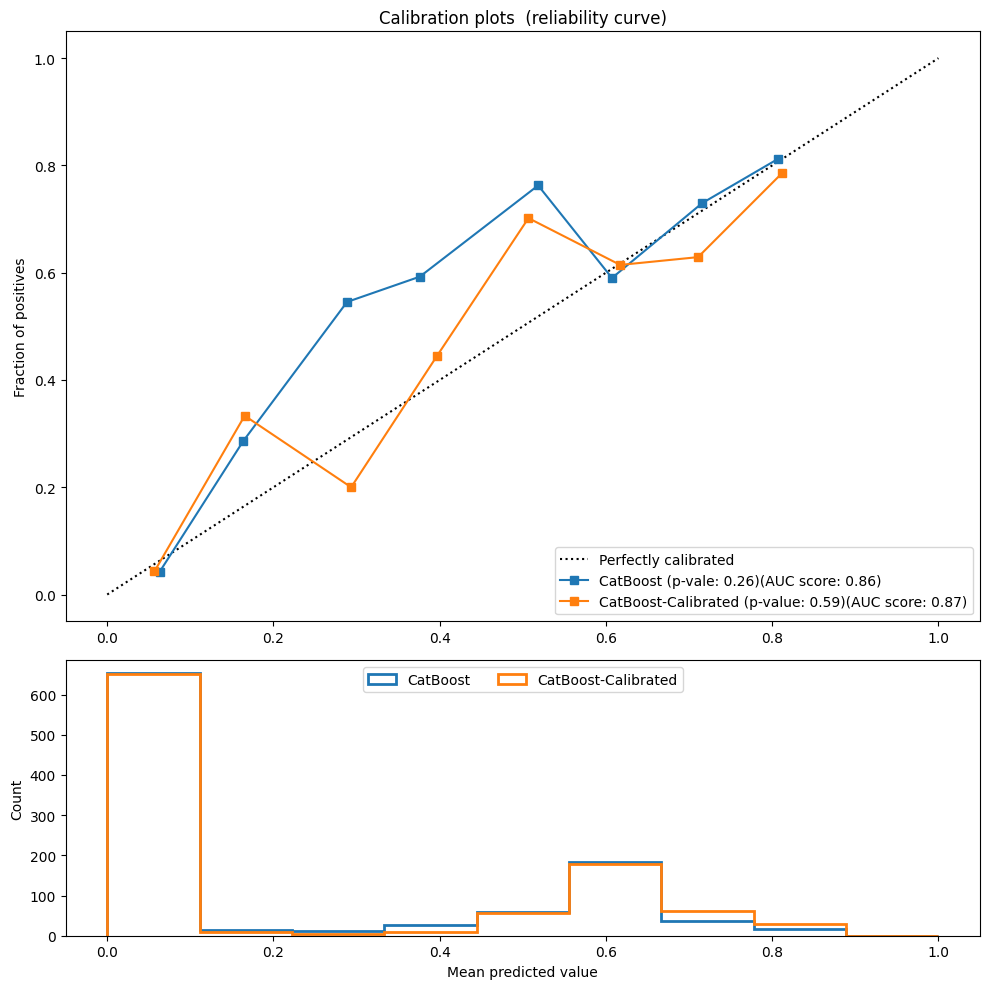

In [24]:

fig_index = 1
fig = plt.figure(fig_index, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


fraction_of_positives, mean_predicted_value = \
    calibration_curve(y, y_prob, n_bins=CFG.n_bins)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
            label="%s (p-vale: %.2f)(AUC score: %.2f)" % ('CatBoost', kolmogorov_smirnov_p_value(y, y_prob), auc_score))

ax2.hist(y_prob, range=(0, 1), bins=CFG.n_bins, label='CatBoost',
            histtype="step", lw=2)

fraction_of_positives, mean_predicted_value = \
    calibration_curve(y, y_cali_prob, n_bins=CFG.n_bins)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
            label="%s (p-value: %.2f)(AUC score: %.2f)" % ('CatBoost-Calibrated', kolmogorov_smirnov_p_value(y, y_cali_prob), calibrated_auc_score))

ax2.hist(y_cali_prob, range=(0, 1), bins=CFG.n_bins, label='CatBoost-Calibrated',
            histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

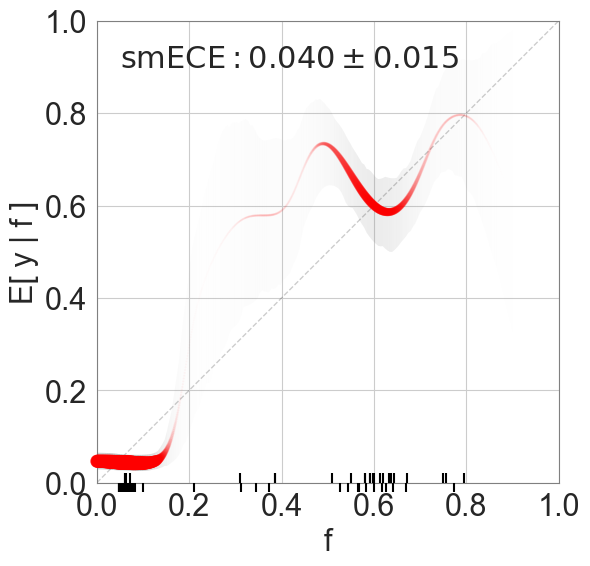

In [25]:
calib_error = rp.smECE(y_prob, y)   # compute calibration error (scalar)
fig, ax = rp.rel_diagram(y_prob, y) # plot

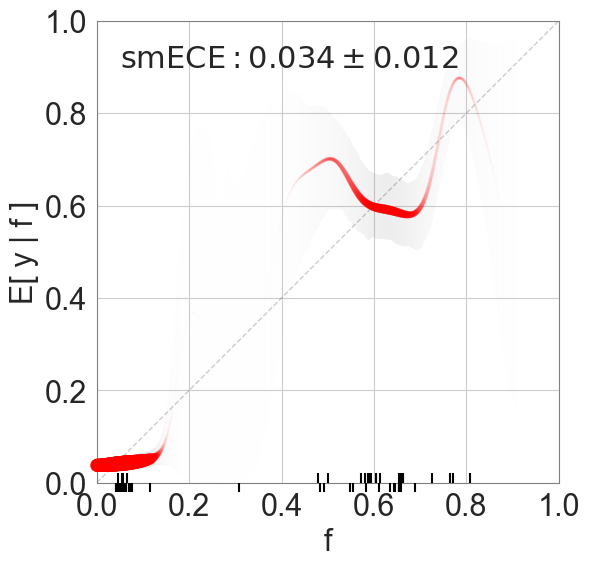

In [26]:
calib_error = rp.smECE(y_cali_prob, y)   # compute calibration error (scalar)
fig, ax = rp.rel_diagram(y_cali_prob, y) # plot